# Character-level Convolutional Networks for text Classification

## Crepe model implementation with MXNet/Gluon

This is an implementation of [the crepe model, Character-level Convolutional Networks for Text Classification](https://arxiv.org/abs/1509.01626) using the MXNet Gluon API. That this is the paper we reference throughout the tutorial

We are going to perform a **text classification** task, trying to classify Amazon reviews according to the product category they belong to.

This work is inspired from a previous collaborative work with [Ilia Karmanov and Miguel Fierro](https://github.com/ilkarman/NLP-Sentiment)

![img](https://github.com/ThomasDelteil/TextClassificationCNNs_MXNet/blob/master/data/diagram.png?raw=true)
![img](https://github.com/ThomasDelteil/TextClassificationCNNs_MXNet/blob/master/data/convolutional_layers.png?raw=true)
![img](https://github.com/ThomasDelteil/TextClassificationCNNs_MXNet/blob/master/data/dense_layer.png?raw=true)


## Data download
The dataset has been made available on this website: http://jmcauley.ucsd.edu/data/amazon/, citation of relevant papers:

**Ups and downs: Modeling the visual evolution of fashion trends with one-class collaborative filtering**
R. He, J. McAuley
*WWW*, 2016

**Image-based recommendations on styles and substitutes**
J. McAuley, C. Targett, J. Shi, A. van den Hengel
*SIGIR*, 2015




We are downloading a subset of the reviews, the k-core reviews, where k=5. That means that for each category, the dataset has been trimmed to only contain 5 reviews per individual product, and 5 reviews per user.

In [19]:
import os

import mxnet as mx
import pandas as pd

In [7]:
categories = [
    'Home_and_Kitchen',
    'Books', 
    'CDs_and_Vinyl', 
    'Movies_and_TV', 
    'Cell_Phones_and_Accessories',
    'Sports_and_Outdoors', 
    'Clothing_Shoes_and_Jewelry'
]

## Data Pre-processing
We need to perform some pre-processing steps in order to have the data in a format we can use for training (**X**,**Y**)
In order to speed up training and balance the dataset we will only use a subset of reviews for each category.

### Load the data in memory

For each category we load MAX_ITEMS_PER_CATEGORY by randomly sampling the files and shuffling

In [10]:
# Loading data from file if exist
mx.test_utils.download('https://s3.ap-south-1.amazonaws.com/ai-conclave-mxnet/review_data.pkl')
data = pd.read_pickle('review_data.pkl')

If the data is not available in the pickled file, we create it from scratch

Let's visualize the data:

In [11]:
print('Value counts:\n',data['Y'].value_counts())
for i,cat in enumerate(categories):
    print(i, cat)
data.head()

Value counts:
 1.0    250000
6.0    250000
5.0    250000
3.0    250000
2.0    250000
0.0    250000
4.0    194439
Name: Y, dtype: int64
0 Home_and_Kitchen
1 Books
2 CDs_and_Vinyl
3 Movies_and_TV
4 Cell_Phones_and_Accessories
5 Sports_and_Outdoors
6 Clothing_Shoes_and_Jewelry


,X,Y
0,Why didnt I find this sooner!!! | This product...,0.0
1,The only thing weighing it down is the second ...,2.0
2,Good | Works very good with a patch pulled or ...,5.0
3,Good mirror glasses | These are very reflectiv...,6.0
4,"cute, cushy, too small :( | Well, here's anoth...",6.0


### Creating the dataset

In [12]:
import multiprocessing

from mxnet import nd, autograd, gluon
from mxnet.gluon.data import ArrayDataset
from mxnet.gluon.data import DataLoader
import numpy as np

Setting up the parameters for the network

In [13]:
ALPHABET = list("abcdefghijklmnopqrstuvwxyz0123456789-,;.!?:'\"/\\|_@#$%^&*~`+ =<>()[]{}") # The 69 characters as specified in the paper
ALPHABET_INDEX = {letter: index for index, letter in enumerate(ALPHABET)} # { a: 0, b: 1, etc}
FEATURE_LEN = 1014 # max-length in characters for one document
NUM_WORKERS = max(multiprocessing.cpu_count() - 3, 1)# number of workers used in the data loading
BATCH_SIZE = 128 # number of documents per batch

According to the paper, each document needs to be encoded in the following manner:
    - Truncate to 1014 characters
    - Reverse the string
    - One-hot encode based on the alphabet
    
The following `encode` function does this for us

In [39]:
def encode(text):
    encoded = np.zeros([len(ALPHABET), FEATURE_LEN], dtype='float32')
    review = text.lower()[:FEATURE_LEN-1:-1]
    i = 0
    for letter in text:
        if i >= FEATURE_LEN:
            break;
        if letter in ALPHABET_INDEX:
            encoded[ALPHABET_INDEX[letter]][i] = 1
        i += 1
    return encoded

The MXNet DataSet and DataLoader API lets you create different worker to pre-fetch the data and encode it the way you want, in order to prevent your GPU from starving

In [40]:
def transform(x, y):
    ####

We split our data into a training and a testing dataset

In [16]:
split = 0.8
split_index = int(split*len(data))
train_data_X = data['X'][:split_index].as_matrix()
train_data_Y = data['Y'][:split_index].as_matrix()
test_data_X = data['X'][split_index:].as_matrix()
test_data_Y = data['Y'][split_index:].as_matrix()

In [20]:
### Create dataset
train_dataset = ####
test_dataset = ####

Creating the training and testing dataloader, with NUM_WORKERS

In [41]:
train_dataloader = DataLoader(train_dataset.transform(transform), batch_size=BATCH_SIZE, shuffle=True, last_batch='rollover', num_workers=NUM_WORKERS)

In [66]:
test_dataloader = DataLoader(test_dataset.transform(transform), batch_size=BATCH_SIZE, shuffle=False, last_batch='rollover', num_workers=NUM_WORKERS)

## Creation of the network

The context will define where the training takes place, on the CPU or on the GPU

In [43]:
ctx = mx.gpu() if mx.context.num_gpus() else mx.cpu()

We create the network following the instructions describe in the paper, using the small feature and small output units configuration

Based on the paper we set the following parameters:

In [44]:
NUM_FILTERS = 256 # number of convolutional filters per convolutional layer
NUM_OUTPUTS = len(categories) # number of classes
FULLY_CONNECTED = 1024 # number of unit in the fully connected dense layer
DROPOUT_RATE = 0.5 # probability of node drop out
LEARNING_RATE = 0.001 # learning rate of the gradient
MOMENTUM = 0.9 # momentum of the gradient
WDECAY = 0.00001 # regularization term to limit size of weights

In [60]:
net = gluon.nn.HybridSequential()
with net.name_scope():
    net.add(gluon.nn.Conv1D(channels=NUM_FILTERS, kernel_size=7, activation='relu'))
    net.add(gluon.nn.MaxPool1D(pool_size=3, strides=3))
    net.add(gluon.nn.Conv1D(channels=NUM_FILTERS, kernel_size=7, activation='relu'))
    net.add(gluon.nn.MaxPool1D(pool_size=3, strides=3))
    net.add(gluon.nn.Conv1D(channels=NUM_FILTERS, kernel_size=3, activation='relu'))
    net.add(gluon.nn.Conv1D(channels=NUM_FILTERS, kernel_size=3, activation='relu'))
    net.add(gluon.nn.Conv1D(channels=NUM_FILTERS, kernel_size=3, activation='relu'))
    net.add(gluon.nn.Conv1D(channels=NUM_FILTERS, kernel_size=3, activation='relu'))
    net.add(gluon.nn.MaxPool1D(pool_size=3, strides=3))
    net.add(gluon.nn.Flatten())
    net.add(gluon.nn.Dense(FULLY_CONNECTED, activation='relu'))
    net.add(gluon.nn.Dropout(DROPOUT_RATE))
    net.add(gluon.nn.Dense(FULLY_CONNECTED, activation='relu'))
    net.add(gluon.nn.Dropout(DROPOUT_RATE))
    net.add(gluon.nn.Dense(NUM_OUTPUTS))


Here we define whether we load a pre-trained version of the model and [hybridize the network](https://mxnet.incubator.apache.org/tutorials/gluon/hybrid.html) for speed improvements

In [61]:
hybridize = True # for speed improvement, compile the network but no in-depth debugging possible

### Parameter initialization

In [62]:
net.initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)

In [63]:
shape = (1, len(ALPHABET), FEATURE_LEN)
net.summary(mx.nd.zeros(shape, ctx))

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                               (1, 69, 1014)               0
        Activation-1   <Symbol hybridsequential2_conv0_relu_fwd>               0
        Activation-2                              (1, 256, 1008)               0
            Conv1D-3                              (1, 256, 1008)          123904
         MaxPool1D-4                               (1, 256, 336)               0
        Activation-5   <Symbol hybridsequential2_conv1_relu_fwd>               0
        Activation-6                               (1, 256, 330)               0
            Conv1D-7                               (1, 256, 330)          459008
         MaxPool1D-8                               (1, 256, 110)               0
        Activation-9   <Symbol hybridsequential2_conv2_relu_fwd>               0
       Activation-10        

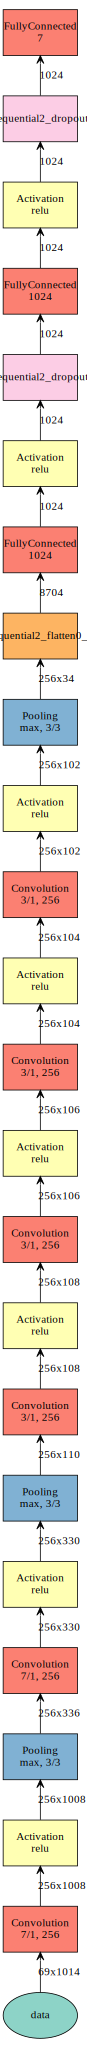

In [65]:
mx.viz.plot_network(net(mx.sym.var('data')), shape={'data':shape})

### Hybridization

In [49]:
if hybridize:
    net.hybridize(static_alloc=True, static_shape=True)

### Softmax cross-entropy Loss

We are in a multi-class classification problem, so we use the [Softmax Cross entropy loss](https://deepnotes.io/softmax-crossentropy)

In [50]:
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

### Optimizer

In [51]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', 
                        {'learning_rate': LEARNING_RATE, 
                         'wd':WDECAY, 
                         'momentum':MOMENTUM})

### Evaluate Accuracy

In [52]:
def evaluate_accuracy(data_iterator, net):
    acc = mx.metric.Accuracy()
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        output = net(data)
        prediction = nd.argmax(output, axis=1)
        acc.update(preds=prediction, labels=label)
    return acc.get()[1]

### Training Loop
We loop through the batches given by the data_loader. These batches have been asynchronously fetched by the workers.

After an epoch, we measure the test_accuracy and save the parameters of the model

In [ ]:
start_epoch = 0
number_epochs = 3
smoothing_constant = .01
for e in range(start_epoch, number_epochs):
    for i, (review, label) in enumerate(train_dataloader):
        review = review.as_in_context(ctx)
        label = label.as_in_context(ctx)
        with autograd.record():
            output = ####
            loss = ####
        loss.####
        trainer.####
        
        # moving average of the loss
        curr_loss = nd.mean(loss)
        moving_loss = (curr_loss if (i == 0) 
                       else (1 - smoothing_constant) * moving_loss + (smoothing_constant) * curr_loss)

        if (i%200 == 0):
            print('Batch {}: Instant loss {:.4f}, Moving loss {:.4f}'.format(i,curr_loss.asscalar(), moving_loss.asscalar()))

    test_accuracy = evaluate_accuracy(test_dataloader, net)
    #Save the model using the gluon params format
    net.save_parameters('crepe_epoch_{}_test_acc_{}.params'.format(e,int(test_accuracy*10000)/100))
    print("Epoch {}. Loss: {:.4f}, Test_acc {:.4f}".format(e, moving_loss.asscalar(), test_accuracy))

### Export to the symbolic format
The `save_params()` method works for models trained in Gluon. 

However the `export()` function, exports it to a format usable in the symbolic API, if you wanted to use in C++ or Scala for example.

In [40]:
net.export('crepe', epoch=number_epochs)

### Random testing

Let's randomly pick a few reviews and see how the classifier does!

In [54]:
import random
for i in range(5):
    index = random.randint(1, len(data))
    review = data['X'][index]
    label = categories[int(data['Y'][index])]
    print(review)
    print('\nCategory: {}\n'.format(label))
    encoded = nd.array([encode(review)], ctx=ctx)
    output = net(encoded)
    predicted = categories[np.argmax(output[0].asnumpy())]
    if predicted == label:
          print('Correct')
    else:
          print('Incorrectly predicted {}'.format(predicted))

Super easy Espresso drinks | This machine makes espresso drinks very easy, fast, and tasty. I have a very nice tradional espresso machine with portafilter. I can make a fantasic shot of espresso with The tradional machine but it takes me about three times longer to prepar then with the Capresso Ultima. The Capresso makes a pretty darn good shot also. Its so easy to use and it cleans up easy. It looks and feels sort of cheap with all the plasic but if it works flawlessly for a few years I can overlook the cheap plastic feel. My tradional machine wheights about 35lbs the Capresso wheights about 1/3 of that wheight. I talk about the weight a lot becous in my exprince heavy steel things tend to last longer the cheap plasic. Not to say that the Capresso Ultima is cheap, Its not. I just dont trust all the plastic. I gess that if they would have used more steel the price would have been a lot higher. At the price point it is, its very afordable for the quality of the drinks you can make with 

### Manual Testing
We can also write our own reviews, encode them and see what the model predicts

In [57]:
review_title = "Good stuff"
review = "This movie is definitely better than the previous one"

In [58]:
print(review_title)
print(review + '\n')
encoded = nd.array([encode(review + " | " + review_title)], ctx=ctx)
output = net(encoded)
softmax = nd.exp(output) / nd.sum(nd.exp(output))[0]
predicted = categories[np.argmax(output[0].asnumpy())]
print('Predicted: {}\n'.format(predicted))
for i, val in enumerate(categories):
    print(val, float(int(softmax[0][i].asnumpy()*1000)/10), '%')

Good stuff
This movie is definitely better than the previous one

Predicted: Movies_and_TV

Home_and_Kitchen 10.7 %
Books 10.7 %
CDs_and_Vinyl 20.9 %
Movies_and_TV 27.7 %
Cell_Phones_and_Accessories 7.4 %
Sports_and_Outdoors 12.5 %
Clothing_Shoes_and_Jewelry 9.8 %


# Model Deployment

Head over to the `model/` folder and have a look at the README.md to learn how you can deploy this pre-trained model to MXNet Model Server. You can then package the API in a docker container for cloud deployment!

An interactive live demo is available [here](https://thomasdelteil.github.io/CNN_NLP_MXNet/)

[![img](https://user-images.githubusercontent.com/3716307/48382335-6099ae00-e695-11e8-8110-f692b9ecb831.png)](https://thomasdelteil.github.io/CNN_NLP_MXNet/)